Как-то захотелось поразбираться как работает критерий Колмогорова для проверки гипотез о функции распределения

**Содержание**<a id='toc0_'></a>    
- [Что удалось понять](#toc1_)    
- [Критерий Колмогорова](#toc2_)    
- [Плотность распределения Колмогорова](#toc3_)    
- [Монте-Карло](#toc4_)    
- [Квантили распределения Колмогорова](#toc5_)    
  - [Точноть и скорость вычисления приближений](#toc5_1_)    
- [Пример](#toc6_)    
- [Проверим критерием Колмогорова несколько гипотез](#toc7_)    
  - [На более крупных выборках](#toc7_1_)    
- [Мощность критерия](#toc8_)    
- [Как устроен критерий Колмогорова в R](#toc9_)    
- [Заметки на полях](#toc10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Что удалось понять](#toc0_)

Встроенный в R метод расчета распределения Колмогорова работает немного быстрее наивной реализации (с простой суммой до 10-15 элементов предельного ряда распределения Колмогорова) при n менее 25. При больших n его скорость падает если "на глаз" то пропорционально $\sqrt n$.

Точность встроенного метода, значимо выше при n<20. Наивный метод дает максимальную прибавку к уровню значимости (т.е. завышает вероятность ошибки 1 рода) порядка 0.6-0.8 п.п. при n=5 и почти никак не влияет на статистику уже при n > 20.

**При n=5 самодельный критерий Колмогорова на 0.001 менее мощный, чем встроенный (дает ошибок 2 рода на 0.1% больше)**

Если применять критерий Колмогорова для n>20, то необходимости в столь сложной реализации приближения распределения Колмогорова практически нет, он без последствий заменяется простым суммированием первых 10-15 элементов ряда распределения Колмогорова, что к тому же на порядок быстрее вычисляется.

Моделирование плотности вероятности показывает, что при n=5 она действительно устроена более сложно, чем гладки вид наивного приближения.

Существенное отличие встроенного приближения при $n \in [5,20]$ (а значит и действительный вид распределения Колмогорова при малых n) от простой аппроксимации предельного распределения скрывает какое-то очень важное свойство теорвера, которое осилить могут не только лишь все, мало кто может это сделать

Метод стороннего пакета KSgeneral хоть и по точности не отличается от встроенного, то крайне медленный и нестабильный при вычислении, т.е. фактически ограниченно пригоден к использованию в моделировании типа Монте-Карло / "бутстрап"

**Вывод, если n>20 и нужно много моделировать (Монте-Карло / бутстрап) - не использовать встроенный вариант.** 


**Отвутствие аналитического выражения для распределения Колмогорова в зависимости от объема выборки и необычные свойства его существующих аппроксимаций не оставляют сомнений, что оно все еще скрывает в себе немало научных загадок и практических сюрпризов**

# <a id='toc2_'></a>[Критерий Колмогорова](#toc0_)

Односторонние варианты статистики критерия

<img src="./img/kolmogorov.png" width="400">

Статистика критерия:
$$D_n(X_{[n]}) = \underset {x \in R} \sup |F_n^*(x) - F_0(x)|$$

\*) т.е. другими словами статистика критерия это максимальная разница теоретической и эмпирической ф.р. Она будет иметь место в точках границ интервалов разбиения области определения x. 

Использование точной верхней грани (супремума) обусловнено необходимостью обобщения в доказательствах, связанных в данной статистикой, с использованием пределов последовательностей.  
По простому, на практике это - максимум разности теоретических вероятностей и наблюдаемых частот в точках выборки.


А.Н.Колмогоровым доказано (1933):

$$\begin{equation*}
    \begin{cases}
        H_0 \Rightarrow D_n(X_{[n]}) \underset {n\rightarrow \infty} {\overset {п.н.} \longrightarrow} 0
        \\
        H_1 \Rightarrow D_n(X_{[n]}) \underset {n\rightarrow \infty} {\overset {п.н.} \longrightarrow} \underset {x \in R} \sup |G(x) - F_0(x)| > 0
    \end{cases}
\end{equation*}$$

\*) "почти наверное" - самый сильный вид сходимости последовательностей (последовательность сходится к с.в. везде, кроме счетного множества точек, может и вообще пустого)

**Теорема Колмогорова**  
если верна $H_0$ и $F_0$ непрерывна, то:
$$\forall z \in R, P\{\sqrt n D_n(X_{[n]}<z)\}\rightarrow K(z) = 1 + 2\sum_{m=1}^{\infty}(-1)^me^{-2m^2z^2}$$

Критическая область:
$$V_k|H_0 = \{\sqrt n D_n(X_{[n]}) > d_{1-\alpha}\}$$
- отличия больше критических для данного уровня значимости => Н0 отвергается  

\*) $d_{1-\alpha}$ - квантиль распределения Колмогорова с ф.р. $K(z)$ (на самом деле  $K_n(z)$, точный аналитический вид которой на сегодняшний день науке неизвестен)

In [2]:
suppressMessages(library(ggplot2))
# install.packages("latex2exp")
suppressMessages(library(latex2exp))    # правда ggplot2 далеко не везде понимает такие подписи
# install.packages("KSgeneral")
suppressMessages(library(KSgeneral))    # https://cran.r-project.org/web/packages/KSgeneral/KSgeneral.pdf

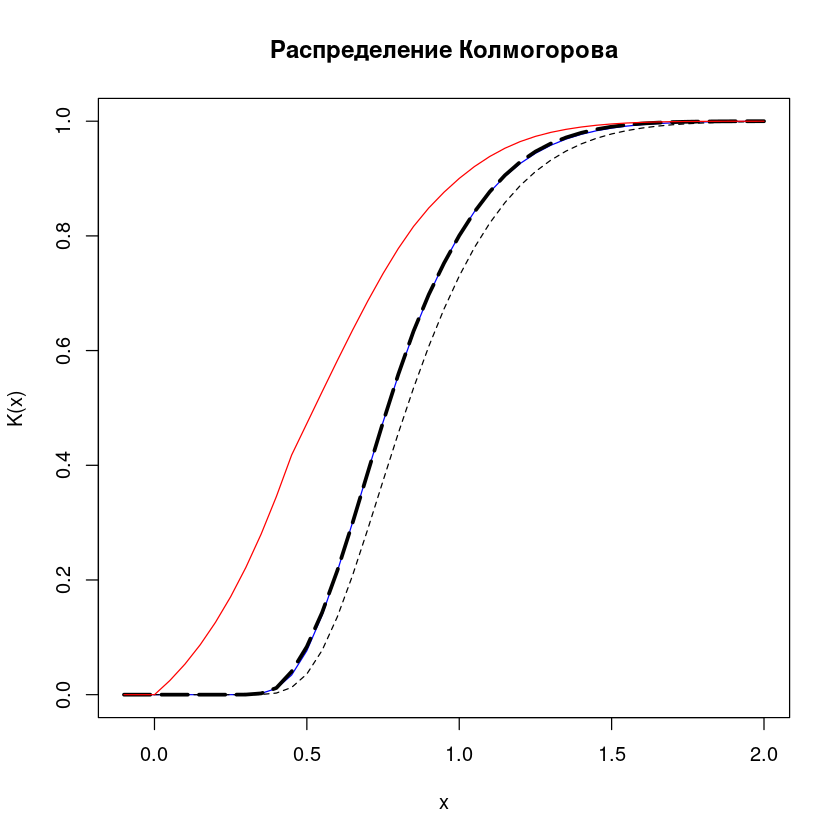

In [3]:
# приближенные значения функции распределения Колмогорова
kolmogorov.cdf.1x <- function(x, n) {
    # приближенное распределение статистки D.plus (используется в критерии Смирнова)
    x <- x / sqrt(n)
    if (x <= 0) return(0)
    if (x >= 1) return(1)
    j <- seq.int(from = 0, to = floor(n * (1 - x)))

    # каноничная степенная форма (работает быстрее при n < 100, см. "подвал")
    1 - x*sum(choose(n, j)*(1-x-j/n)^(n-j)*(x+j/n)^(j-1))

    # в R используется логарифмическая форма (работает быстрее при n > 100)
    1 - x * sum(exp(lchoose(n, j) + (n - j) * log(1 -
        x - j/n) + (j - 1) * log(x + j/n)))
}

kolmogorov.cdf.2x <- function(x, n) {
    # настоящее приближение распределения Колмогорова захардкодено в R 
    # в виде скомпилированной C-функции, алгоритм тут https://www.jstatsoft.org/article/view/v008i18
    x <- x / sqrt(n) # хочет статистику без корня из n
    .Call(stats:::C_pKolmogorov2x, x, n, PACKAGE = "stats") # внутри он сам умножит на корень из n
}

kolmogorov.cdf <- function(x, n, iter = 15, limit = FALSE) {
    # наивная реализация
    if (!limit) # предельный вид распред-я, либо аппрокс. для малых n
        x <- x + 1 / (6 * sqrt(n)) + (x - 1) / (4 * n)
    if (x <= 0.17) return(0) # вероятности <1e-10 не считаем
    m <- seq(1, iter)
    return(1 + 2 * sum((-1)^m * exp(-2*m^2*x^2)))
}

kolmogorov.cdf.ksg <- function(x, n) {
    x[x < 0] <- 0
    suppressWarnings(KSgeneral::cont_ks_cdf(x/sqrt(n), n))
}

kolmogorov.pdf <- function(x, n, func = kolmogorov.cdf, tol = 1e-5) {
    sapply(x, function(x0) (func(x0 + tol/2, n) - func(x0 - tol/2, n)) / tol)
}

n = 5
x <- seq(-0.1, 2, 0.05)

y <- sapply(x, function(x) kolmogorov.cdf(x, n))                    # наивное приближение
y.lim <- sapply(x, function(x) kolmogorov.cdf(x, n, limit = TRUE))  # его предельный вид
y2x <- sapply(x, function(x) kolmogorov.cdf.2x(x, n))       # встроенное приближение 
y1x <- sapply(x, function(x) kolmogorov.cdf.1x(x, n))       # встроенное односторонне приближение (при малых n имеет видимый излом)

plot(x = x, y, type = "l", col = "blue",                            # наивное
     main = "Распределение Колмогорова", ylab = "K(x)")
lines(x = x, y.lim, type = "l", lty = 2)                            # предельное
lines(x = x, y2x, type = "l", col = "black", lty=5, lwd = 3)        # встроенное
lines(x = x, y1x, type = "l", col = "red")                          # одностороннее для D.plus

https://arxiv.org/pdf/1803.00426.pdf 

Для статистики $D^+$  используется точная формула для вероятности (Н.В.Смирнов, 1944). Формула представляет собой многочлен степени n являющийся сплайном с узлами на границах интервалов разбиения. 

Излом (разрыв производной) распределения в точке 0.447 - соответствует значению статистики Колмогорова с точке 1/n = 1/5).

    этот излом означает, что ситуация когда эмпирическое распределение превосходит теоретическое на максимум 1/n является такой особой точкой, 
    где скорость роста вероятности превосходить теорет.распр. не менее чем на эту величину меняется скачкообразно!

При n>5 излом также имеет место, просто расположен левее (в 1/n) и менее заметен визуально

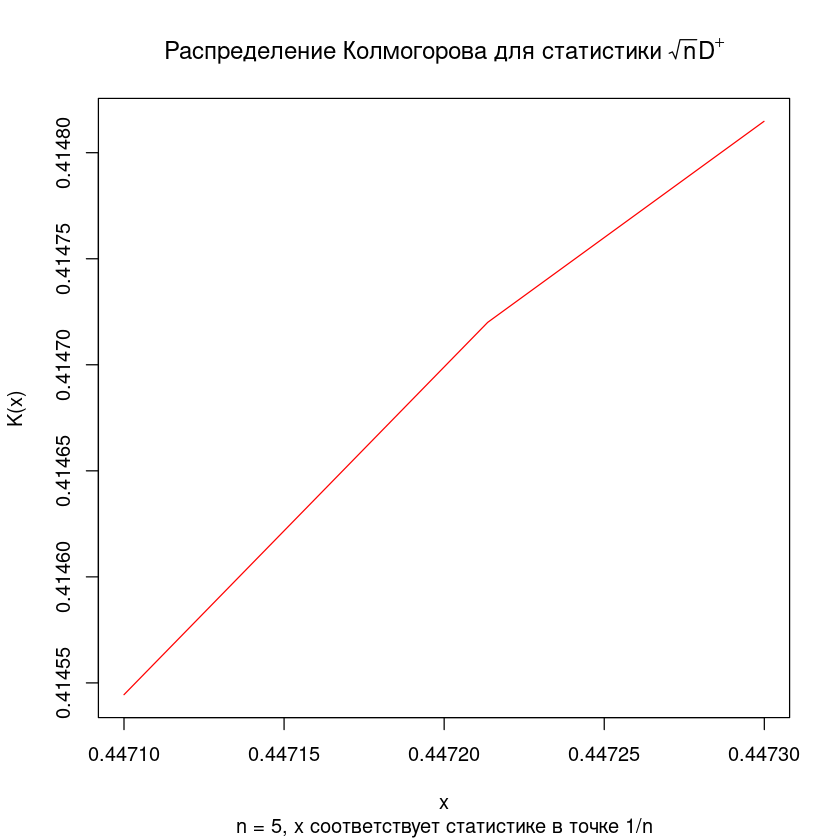

In [4]:
x <- seq(0.4471, 0.4473, 0.0000001)
y1x <- sapply(x, function(x) kolmogorov.cdf.1x(x, n))       # встроенное односторонне приближение (при малых n имеет видимый излом)
plot(x = x, y1x, type = "l", col = "red",                   
     main = TeX("Распределение Колмогорова для статистики $\\sqrt{n} D^+$"),
     sub = "n = 5, x соответствует статистике в точке 1/n", ylab = "K(x)")

# <a id='toc3_'></a>[Плотность распределения Колмогорова](#toc0_)

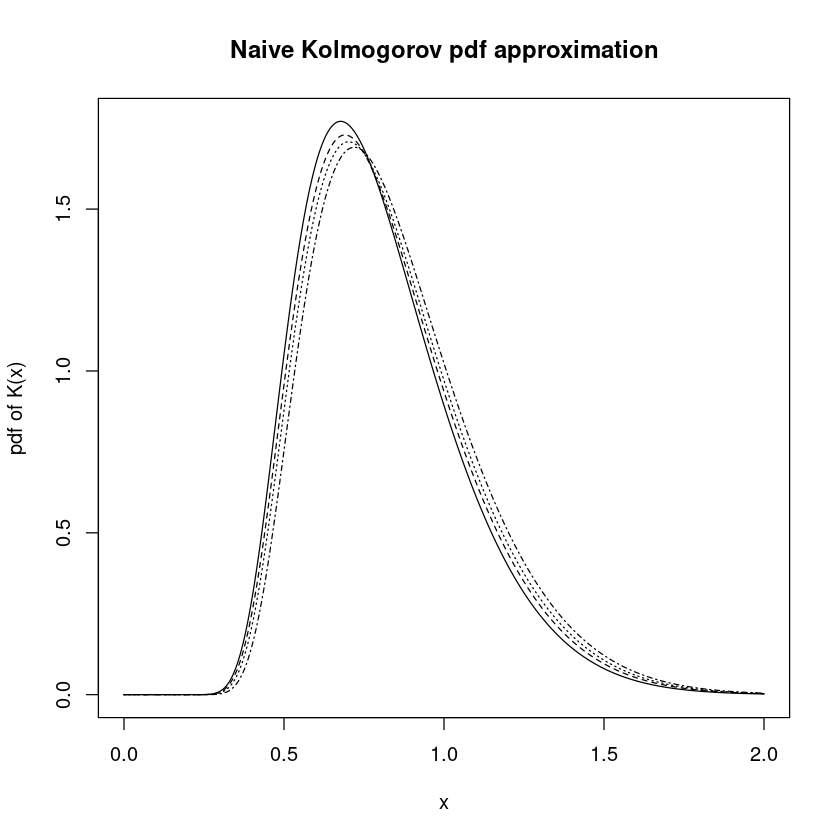

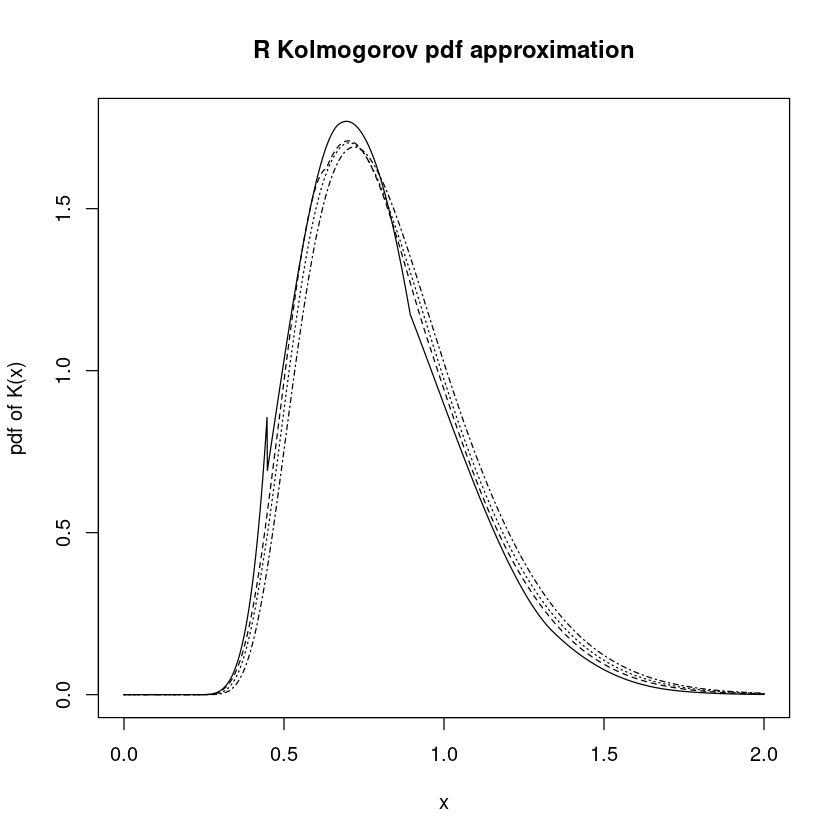

In [5]:
x = seq(0, 2, 0.001)

plot(x, kolmogorov.pdf(x, 5), type = "l", main = "Naive Kolmogorov pdf approximation", ylab = "pdf of K(x)")
lines(x, kolmogorov.pdf(x, 10), type = "l", lty = 2)
lines(x, kolmogorov.pdf(x, 20), type = "l", lty = 3)
lines(x, kolmogorov.pdf(x, 100), type = "l", lty = 4)

plot(x, kolmogorov.pdf(x, 5, func = kolmogorov.cdf.2x), type = "l", main = "R Kolmogorov pdf approximation", ylab = "pdf of K(x)")
lines(x, kolmogorov.pdf(x, 10, func = kolmogorov.cdf.2x), type = "l", lty = 2)
lines(x, kolmogorov.pdf(x, 20, func = kolmogorov.cdf.2x), type = "l", lty = 3)
lines(x, kolmogorov.pdf(x, 100, func = kolmogorov.cdf.2x), type = "l", lty = 4)

Почему такая форма в районе 1/n? Загадка

Квантовый скачок вероятности! Сингулярность экстремального наблюдения в выборке! 

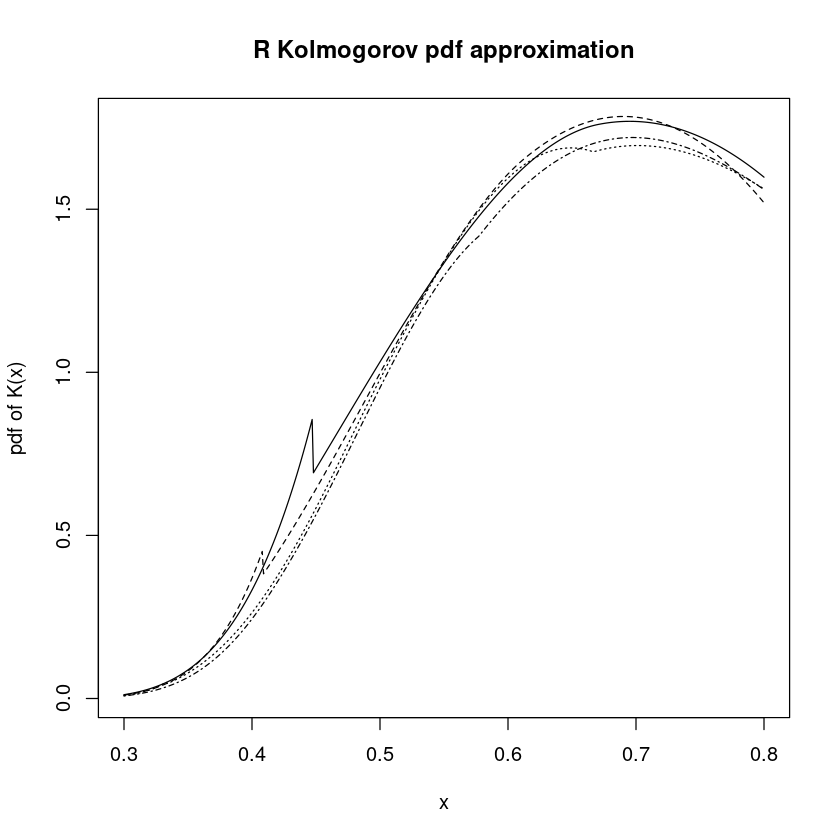

In [6]:
x = seq(0.3, 0.8, 0.001)
plot(x, kolmogorov.pdf(x, 5, func = kolmogorov.cdf.2x), type = "l", main = "R Kolmogorov pdf approximation", ylab = "pdf of K(x)")
lines(x, kolmogorov.pdf(x, 6, func = kolmogorov.cdf.2x), type = "l", lty = 2)
lines(x, kolmogorov.pdf(x, 9, func = kolmogorov.cdf.2x), type = "l", lty = 3)
lines(x, kolmogorov.pdf(x, 12, func = kolmogorov.cdf.2x), type = "l", lty = 4)

Неужели вот так ведет себя вероятность отклонения, что она вдруг раз и уменьшается, а потом дальше растет? Монте-Карло показывает, что как минимум гладкость ф.р. точно меняется в этой точке.

Объяснения нигде не попадалось...

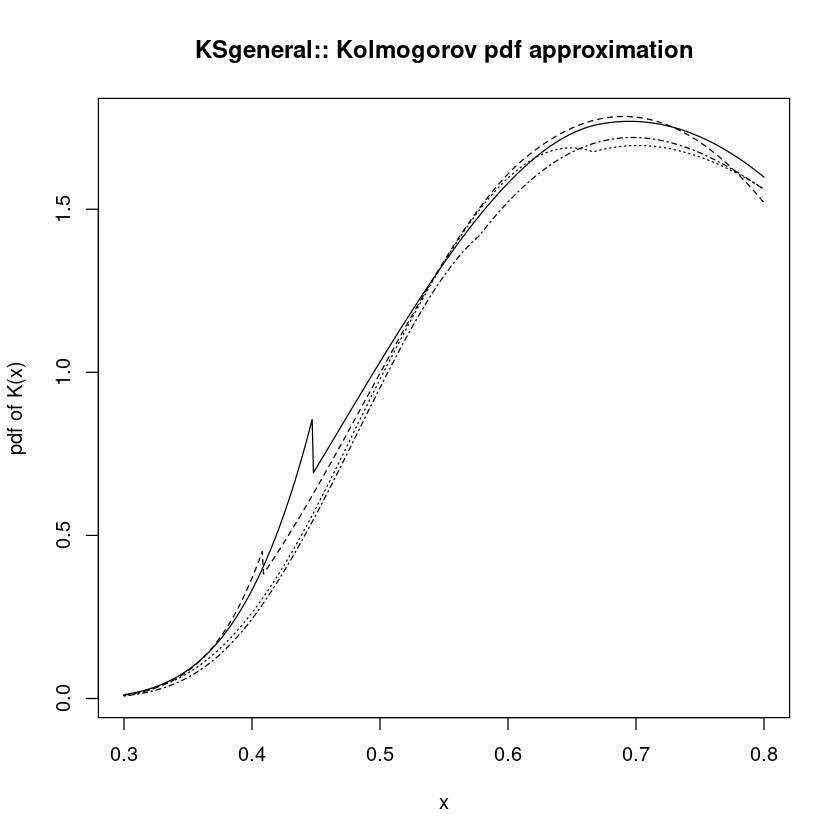

In [7]:
x = seq(0.3, 0.8, 0.001)
plot(x, kolmogorov.pdf(x, 5, func = kolmogorov.cdf.ksg), type = "l", main = "KSgeneral:: Kolmogorov pdf approximation", ylab = "pdf of K(x)")
lines(x, kolmogorov.pdf(x, 6, func = kolmogorov.cdf.ksg), type = "l", lty = 2)
lines(x, kolmogorov.pdf(x, 9, func = kolmogorov.cdf.ksg), type = "l", lty = 3)
lines(x, kolmogorov.pdf(x, 12, func = kolmogorov.cdf.ksg), type = "l", lty = 4)

# <a id='toc4_'></a>[Монте-Карло](#toc0_)

Моделирование плотности вероятности статистики Колмогорова методом Монте-Карло на стандартном нормальном распределении показало, что график действительно имеет хитрую ломанную форму при n = 5 очень похожую на приближения из встроенного в R метода.

- 1e+6 испытаний, 16.5 минут расчетов:

<img src="./img/real_kolmogorov.png" width="400">

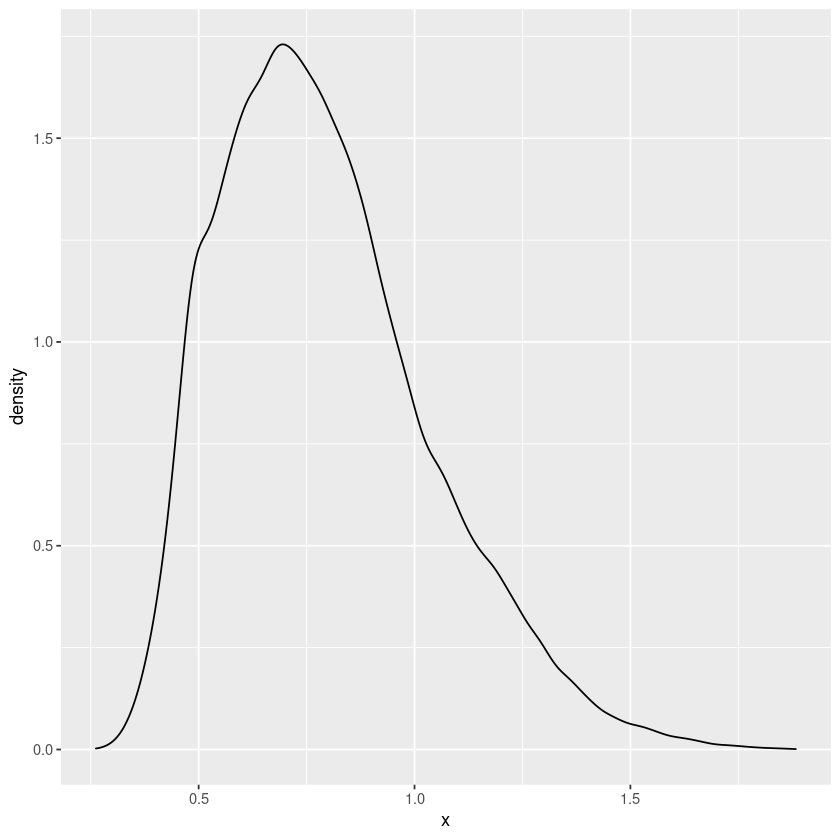

In [8]:
K.stat <- function(x, n) {
    x      <- pnorm(sort(x)) - (0:(n - 1)) / n    
    return(sqrt(n) * max(c(x, 1/n - x)))
}

N <- 100000
n <- 4
K <- sapply(seq(1,  N), function(.) K.stat(rnorm(n), n))

# png("./img/real_kolmogorov.png")
ggplot(data.frame(x=K), aes(x)) +
    geom_density()
# dev.off()

Cмотрим на приближение распределения Колмогорова, встроенного в R, приведенное к виду плотности вероятности.

Если рассмотреть диапазон значений $x\in [0.2, 0.25]$ и $n\in [5, 10]$ (cоответствуют очень малым отклонениями эмпирического распределения от теоретического) наблюдается любопытная картина:

    с ростом объема выборки вероятность максимально отклониться на величину 0.225 от любого теоретического распределения - растет, а после объема 10 элементов - снижается
    что за волшебный объем выборки 10 элементов?

Любопытно также устройство функции распределения в наиболее "рабочей" области критерия, при $x\simeq 0.48$ (что соответствует вероятности ошибок 1 рода порядка 5%) - именно за счет этого отличия обеспечивается на 0,1% более высокая мощность критерия Колмогорова при использовании встроенного приближения по сравнению с наивной реализацией. Оно несколько выше, т.е. критерий несколько чаще отклоняет нулевую гипотезу, а т.к. оно при этом ближе к реальному распределению Колмогорова при соответствующих n, оно отклоняет нулевую гипотезу справедливо.

Аналогичная картина с $x\simeq 0.42$ (соответствует вероятности ош. 1 рода порядка 1%).

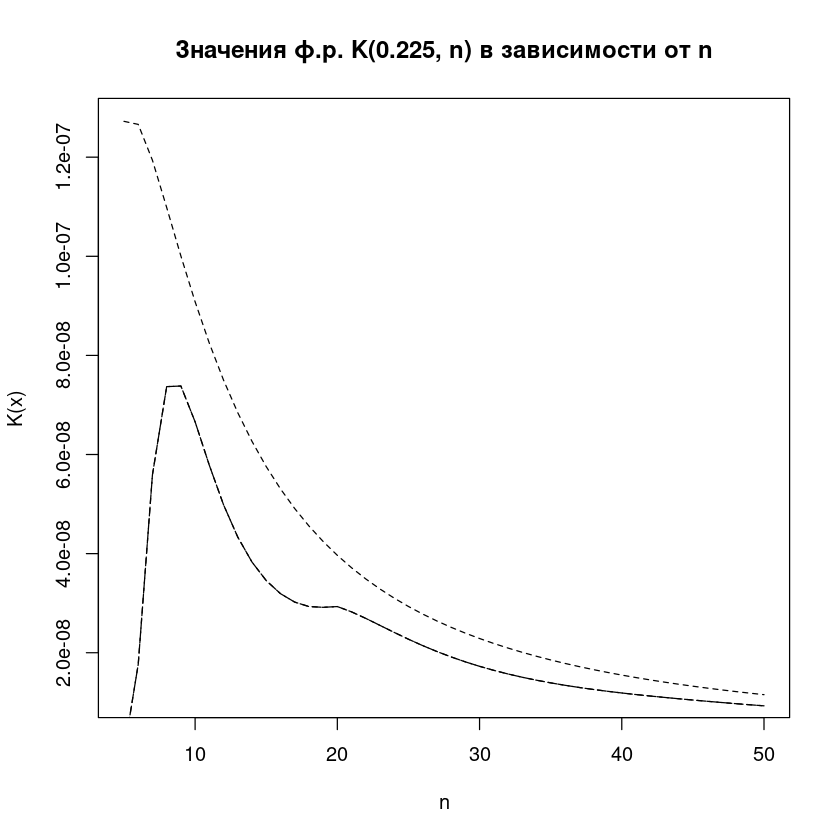

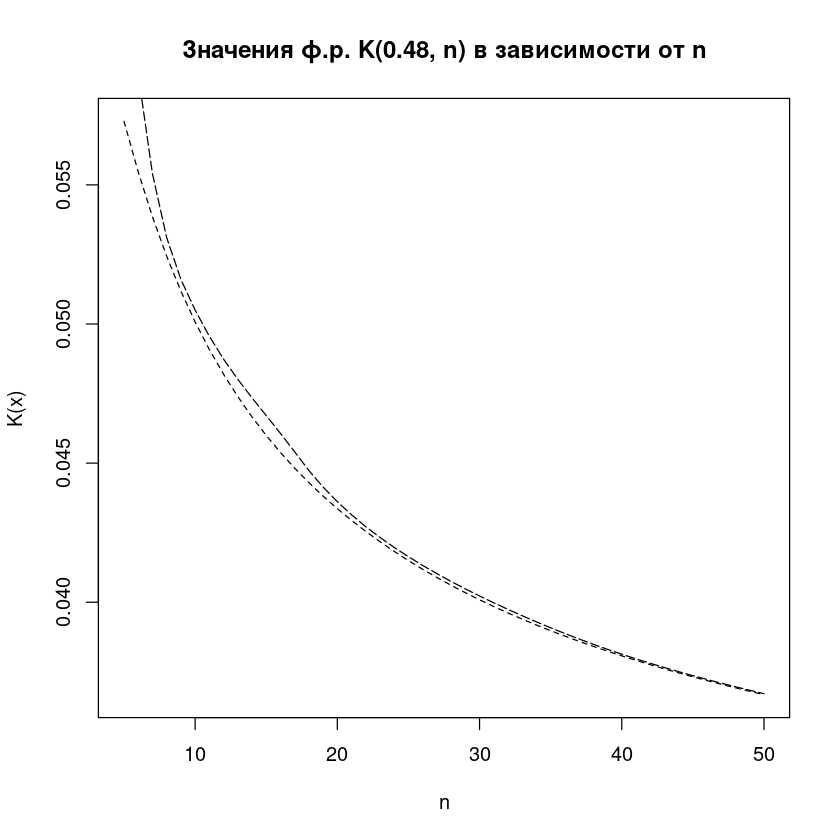

In [9]:
x = 0.225
n = 5:50
plot(n, sapply(n, function(n) kolmogorov.cdf(x, n)), 
     main = "Значения ф.р. K(0.225, n) в зависимости от n", 
     ylab="K(x)", type="l", lty = 2)                                            # наивное моделирование
lines(n, sapply(n, function(n) kolmogorov.cdf.2x(x, n)), type="l", lty = 5)     # приближение в R
lines(n, sapply(n, function(n) kolmogorov.cdf.ksg(x, n)), type="l", lty = 2)    # приближение в R::KSgeneral полностью совпадает!

x = 0.48
plot(n, sapply(n, function(n) kolmogorov.cdf(x, n)), 
     main = "Значения ф.р. K(0.48, n) в зависимости от n", 
     ylab="K(x)", type="l", lty = 2)                                            # наивное моделирование
lines(n, sapply(n, function(n) kolmogorov.cdf.2x(x, n)), type="l", lty = 5)     # приближение в R

# <a id='toc5_'></a>[Квантили распределения Колмогорова](#toc0_)

In [10]:
bisect <- function(func, ..., a = 0, b = 2, tol = 1e-5) {
    f.a <- func(a, ...)
    f.b <- func(b, ...)
    while (abs(b - a) > tol) {
        xi <- a + (b - a) / 2
        yi <-  func(xi, ...)
        if (sign(f.a) == sign(yi)) { 
            a <- xi
            f.a <- yi
        } else {
            b <- xi
            f.b <- yi
        }
    }
    return((a+b) / 2)
}

kolmogorov.quantile <- function(alpha, n, ..., func = kolmogorov.cdf) {
    f <- function(x, n, alpha, ...) func(x, n, ...) - alpha
    bisect(f, n, alpha)
}

n = 10
alpha = 0.05

c(K.q = kolmogorov.quantile(alpha, n), K.p = kolmogorov.cdf(kolmogorov.quantile(alpha, n), n))
c(K.q.2x = kolmogorov.quantile(alpha, n, func = kolmogorov.cdf.2x), 
  K.p.2x = kolmogorov.cdf.2x(kolmogorov.quantile(alpha, n, func = kolmogorov.cdf.2x), n))

K.q        K.p 
0.47990799 0.04999995

K.q.2x     K.p.2x 
0.47938156 0.05000183

Наивное приближение распределения совпадает вот с этой например таблицей (Новосибирск, НГТУ, НМЦ) с точностью до приведенных в ней данных:

    http://smc.edu.nstu.ru/krit_kolm.htm

Что характерно, встроенный в R вариант для значений близких предельному виду распределения требует параметр n > 5000 и тогда разница составит порядка 0.1% Однако, при этом его вычисления занимают на несколько порядков большее время, чем наивный метод. Поэтому в таблице ниже для него установлено n = 1000. Дожидаться когда это же пересчитает KSgeneral - долго и не интересно.

Попалось также уже древнее постановлением Госстандарта России от 22 января 2002 г. No 24-ст ПРАВИЛА ПРОВЕРКИ СОГЛАСИЯ ОПЫТНОГО РАСПРЕДЕЛЕНИЯ С ТЕОРЕТИЧЕСКИМ (разработанное в том же НГТУ), где приводятся значения функции распределения статистики Колмогорова с точностью до 6 зн. В части точек отличается от наивной реализации распределения на единицу последнего разряда (возможно у кого-то округление по-разному работает).

Там же приводятся такие замечательные слова: **с точки зрения практического использования критериев важны два момента... Во-первых, очевидно, что при малых выборках пытаться различать с помощью непараметрических критериев согласия близкие гипотезы (особенно простые) абсолютно бесполезно. Во-вторых, мощность непараметрических критериев при проверке сложных гипотез при тех же объемах выборок и всегда существенно выше, чем при проверке простых**.

In [11]:
k.quant <- data.frame(x = x <- seq(0.3, 2, 0.1))
k.quant$my.ks.alpha <- round(sapply(x, function(x) 1 - kolmogorov.cdf(x, n = 0, limit = T)), 4)
k.quant$r.ks.aplha <- round(sapply(x, function(x) 1 - kolmogorov.cdf.2x(x, n = 1000)), 4) 

k.quant

x,my.ks.alpha,r.ks.aplha
<dbl>,<dbl>,<dbl>
0.3,1.0000,1.0000
0.4,0.9972,0.9966
0.5,0.9639,0.9606
0.6,0.8643,0.8574
0.7,0.7112,0.7026
0.8,0.5441,0.5357
0.9,0.3927,0.3855
1.0,0.2700,0.2644
1.1,0.1777,0.1736


## <a id='toc5_1_'></a>[Точноть и скорость вычисления приближений](#toc0_)

Про точность:
- при n=5 макимальное отлонение разности наивного и встроенного приближения составляет = 0.0072, среднее = 0.00177 
- при n=10: максимальное = 0.0025, среднее = 0.00064 
- при n=50: максимальное = 0.00029, среднее = 0.00013
- при n=100: максимальное = 0.00016, среднее = 1e-5

- суммирование больше 10 членов ряда **не увеличивают** точность наивного приближение по сравнению с **встроенным** вариантом

Про скорость вычислений:
- при n=5, n=10 встроенный метод примерно в 1,5 быстрее наивного приближения 
- при n=50: встроенный метод примерно в 3 раза **медленнее** наивного приближения 
- при n=100 его вычисления занимают в 5 раз больше времени чем наивный метод
- при n больше 5000 встроенный метод не факт что вообще выдаст какой-то результат за разумное время (может зависнуть)

- встроенный метод показывает более высокую скорость вычислений только для n<25. 

Неудивительно, в расчетах активно используется умножение матриц

Хотя и влияние R обертки для прямого вызова С функций .Call(...) нельзя исключать


In [28]:
n = 10
x <- seq(0.2, 1.9, 0.01)            # KSgeneral за этими пределами не умеет
y1 <- sapply(x, function(x) kolmogorov.cdf(x, n))
y2 <- sapply(x, function(x) kolmogorov.cdf.2x(x, n))
y3 <- sapply(x, function(x) kolmogorov.cdf.ksg(x, n))

list(max.dev = max(abs(y1 - y2)), mean.dev = sd(y1 - y2))   # максимальное и среднее отклонение
list(max.dev = max(abs(y1 - y3)), mean.dev = sd(y1 - y3)) 
list(max.dev = max(abs(y2 - y3)), mean.dev = sd(y2 - y3))   # встроенный и KSgeneral отличаются на 1e-15

x <- runif(10000, min = 0.2, max = 1.9)
k = 10

$max.dev
[1] 0.002483094

$mean.dev
[1] 0.0006863603

$max.dev
[1] 0.002483094

$mean.dev
[1] 0.0006863603

$max.dev
[1] 3.108624e-15

$mean.dev
[1] 9.056213e-16

In [13]:
for (i in 1:k) 
    for (z in x)
        kolmogorov.cdf(z, n)

In [14]:
for (i in 1:k) 
    for (z in x)
        .Call(stats:::C_pKolmogorov2x, z / sqrt(n), n, PACKAGE = "stats")

# <a id='toc6_'></a>[Пример](#toc0_)

Являются ли данные выборкой из нормально распределенной ГС с м.о. 450 и дисперсией 16?
    
    451 450 444 454 447

Такая малая выборка взята для наглядности

In [15]:
data = data.frame(x = sort(scan(textConnection("451 450 444 454 447"))))    # отсортированные данные
n <- nrow(data)
m = 450
sd = 4

data$F0 = pnorm(data$x, m = m, sd = sd) # теоритические вероятности
data$F <- 1:n / n                       # эмпирические вероятности

data$D.minus <- data$F0 - data$F + 1/n  # сделаем так, чтобы отклонения вниз были положительными (для наглядности)
data$D.plus <- data$F - data$F0
data$D <- mapply(max, data$D.minus, data$D.plus)
data

D = max(data$D)

list(D.plus = max(data$D.plus), D.minus = max(data$D.minus), D = D)

x,F0,F,D.minus,D.plus,D
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
444,0.0668072,0.2,0.066807201,0.1331928,0.1331928
447,0.2266274,0.4,0.026627352,0.1733726,0.1733726
450,0.5000000,0.6,0.100000000,0.1000000,0.1000000
451,0.5987063,0.8,-0.001293674,0.2012937,0.2012937
454,0.8413447,1.0,0.041344746,0.1586553,0.1586553


$D.plus
[1] 0.2012937

$D.minus
[1] 0.1

$D
[1] 0.2012937

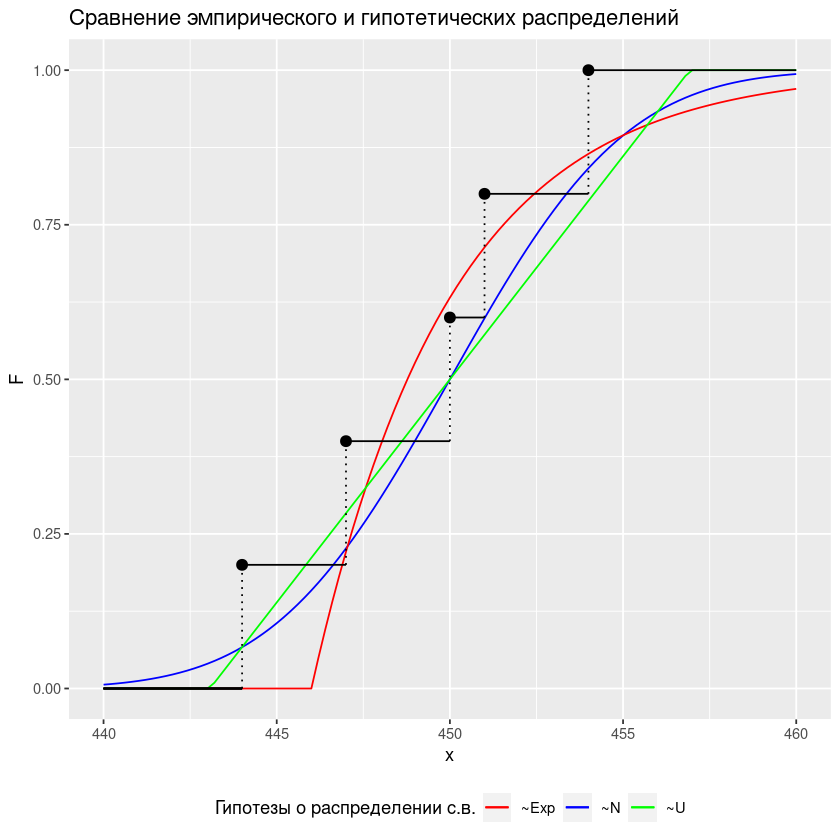

In [16]:
# распределения с одинаковыми параметрами
cdf.1 <- function(x)  pnorm(x, m = m, sd = sd)
cdf.2 <- function(x)  pexp(x - m + sd, r = 1/sd)
cdf.3 <- function(x)  punif(x, min = m - sqrt(sd^2 * 12) / 2, 
                               max = m + sqrt(sd^2 * 12) / 2)

data$x.le <- c(0, rev(rev(data$x)[-1]))
data$x.gr <- c(data$x[-1], m + 10)

ggplot(data) + 
    stat_function(fun = cdf.1, mapping = aes(color = "~N")) + 
    stat_function(fun = cdf.2, mapping = aes(color = "~Exp")) + 
    stat_function(fun = cdf.3, mapping = aes(color = "~U")) + 
    scale_x_continuous(limits = c(m - 10, m + 10)) +
    scale_color_manual(name = "Гипотезы о распределении с.в.", values = c("red", "blue", "green")) + 
    
    geom_pointrange(data, mapping = aes(x=x, y=F, xmin=x, xmax=x.gr)) +
    geom_linerange(data, mapping = aes(y=0, xmin=m-10, xmax=min(x))) +

    geom_linerange(data, mapping = aes(x=x, ymin=F-1/n, ymax=F), linetype="dotted") +

    ggtitle("Сравнение эмпирического и гипотетических распределений") + 
    theme(legend.position="bottom")

# <a id='toc7_'></a>[Проверим критерием Колмогорова несколько гипотез](#toc0_)

Для сравнения выбраны три распределения с одинаковыми м.о. и дисперсией:

    нормальное
    экспоненциальное
    равномерное

Критерий Колмогорова показал с уровнем значимости 0.05

    принятие гипотезы о нормальном распределении
    отклонение гипотез о экспоненциальном и равномерном распределении

При таком минимально целесообразном n встроенный метод показывает на 0.7 п.п. меньший уровень значимости гипотез. В принципе это довольно много.

In [17]:
# упрощенный тест Колмогорова
my.ks.test <- function(x, func, ..., alpha = 0.05, two.methods = TRUE) {
    n      <- length(x)
    x      <- func(sort(x), ...) - (0:(n - 1)) / n    
    D.stat <- max(c(x, 1/n - x))
    K.stat <- sqrt(n) * D.stat
    p.v    <- 1 - kolmogorov.cdf(K.stat, n)         # вероятность, что при Н0 отклонение будет такое или больше
    p.v.2x <- ifelse(two.methods, 1 - kolmogorov.cdf.2x(K.stat, n), p.v)
    list(D.stat = D.stat, K.stat = K.stat, p.v.my = p.v, p.v.2x = p.v.2x,
         H = ifelse(p.v > 1 - alpha, "H0", "H1"))   # Н0 принимается, если вероятность такого и большего отклонения > 1 - alpha
}

# дисперсия и м.о. одинаковые
my.ks.test(data$x, cdf.1)
my.ks.test(data$x, cdf.2)
my.ks.test(data$x, cdf.3)

$D.stat
[1] 0.2012937

$K.stat
[1] 0.4501063

$p.v.my
[1] 0.9657405

$p.v.2x
[1] 0.9595856

$H
[1] "H0"

$D.stat
[1] 0.2321206

$K.stat
[1] 0.5190373

$p.v.my
[1] 0.9018853

$p.v.2x
[1] 0.8954134

$H
[1] "H1"

$D.stat
[1] 0.2278312

$K.stat
[1] 0.5094461

$p.v.my
[1] 0.9130084

$p.v.2x
[1] 0.906176

$H
[1] "H1"

Интересно, что проверка гипотезы экспоненциального распределения могла бы пройти по критерию Колмогорова.

Дело в том, что м.о. и дисперсия у эксп. распределения были приняты в соответствии с Н0, но в этом случае у него есть нижняя граница возможных значений, и туда попала часть наблюдений.

Соответственно в этих точках получилось отклонение эмпирического распределения и данного экспоненциального в рамере величины интервала 1/n, для 5 наблюдений это 0.2, что дало бы p-значение 0.968 (т.е. H0 принимается с уровнем значимости 5%). Если бы например вместо наблюдения 450 (где получилось максимальное отклонение) было бы 449, то отклонения в области определения экспоненциального распределения от эмпирических данных не смогли бы превзойти 1/n, он был бы принят за максимальное отклонение по выборке. В этом случае стат.решение было бы в пользу заведомо невозможного экспоненциального распределения.

**Пример нарушения дизайна задачи, экспоненциальное распределение при таких данных и с такими параметрами в качестве нулевой гипотезы не должно было приниматься**

[1] 0.9675878

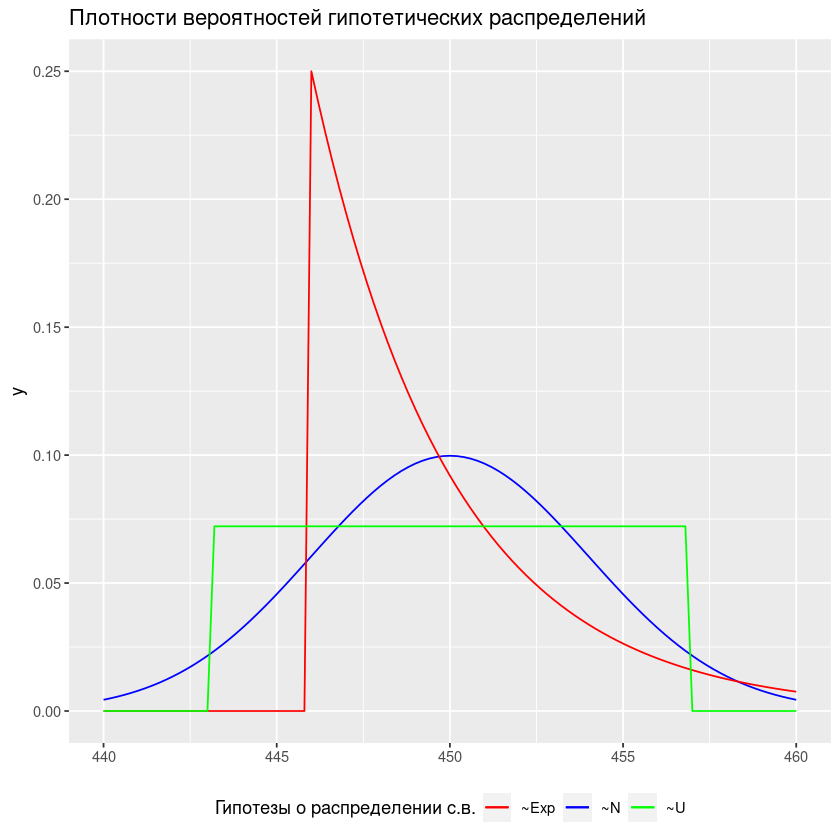

In [29]:
df.1 <- function(x)  dnorm(x, m = m, sd = sd)
df.2 <- function(x)  dexp(x - m + sd, r = 1/sd)
df.3 <- function(x)  dunif(x, min = m - sqrt(sd^2 * 12) / 2, 
                               max = m + sqrt(sd^2 * 12) / 2)

ggplot(data) + 
    stat_function(fun = df.1, mapping = aes(color = "~N")) + 
    stat_function(fun = df.2, mapping = aes(color = "~Exp")) + 
    stat_function(fun = df.3, mapping = aes(color = "~U")) + 
    scale_x_continuous(limits = c(m - 10, m + 10)) +
    scale_color_manual(name = "Гипотезы о распределении с.в.", values = c("red", "blue", "green")) + 

    ggtitle("Плотности вероятностей гипотетических распределений") + 
    theme(legend.position="bottom")

1 - kolmogorov.cdf(0.2*sqrt(5), 5)

In [19]:
x <- data$x
x
x[3] <- 449             # заменим 450 на 449
my.ks.test(x, cdf.2)    # и вот тест показывает, что это похоже на экспоненциальное распределение

[1] 444 447 450 451 454

$D.stat
[1] 0.2

$K.stat
[1] 0.4472136

$p.v.my
[1] 0.9675878

$p.v.2x
[1] 0.9616

$H
[1] "H0"

In [20]:
ks.test(data$x, cdf.1)
ks.test(data$x, cdf.2)
ks.test(x, cdf.2)
ks.test(data$x, cdf.3)


	One-sample Kolmogorov-Smirnov test

data:  data$x
D = 0.20129, p-value = 0.9596
alternative hypothesis: two-sided



	One-sample Kolmogorov-Smirnov test

data:  data$x
D = 0.23212, p-value = 0.8954
alternative hypothesis: two-sided



	One-sample Kolmogorov-Smirnov test

data:  x
D = 0.2, p-value = 0.9616
alternative hypothesis: two-sided



	One-sample Kolmogorov-Smirnov test

data:  data$x
D = 0.22783, p-value = 0.9062
alternative hypothesis: two-sided


In [21]:
cont_ks_test(data$x, cdf.1)


	One-sample Kolmogorov-Smirnov test

data:  data$x
D = 0.20129, p-value = 0.9596
alternative hypothesis: two-sided


## <a id='toc7_1_'></a>[На более крупных выборках](#toc0_)

При выборке n=20 точность встроенного метода уже вообще не вляет на стат.решение по сравнению с простым методом.

$D.stat
[1] 0.1560691

$K.stat
[1] 0.6979621

$p.v.my
[1] 0.6584337

$p.v.2x
[1] 0.6584576

$H
[1] "H1"


	One-sample Kolmogorov-Smirnov test

data:  x
D = 0.15607, p-value = 0.6585
alternative hypothesis: two-sided



	Shapiro-Wilk normality test

data:  x
W = 0.94341, p-value = 0.2779


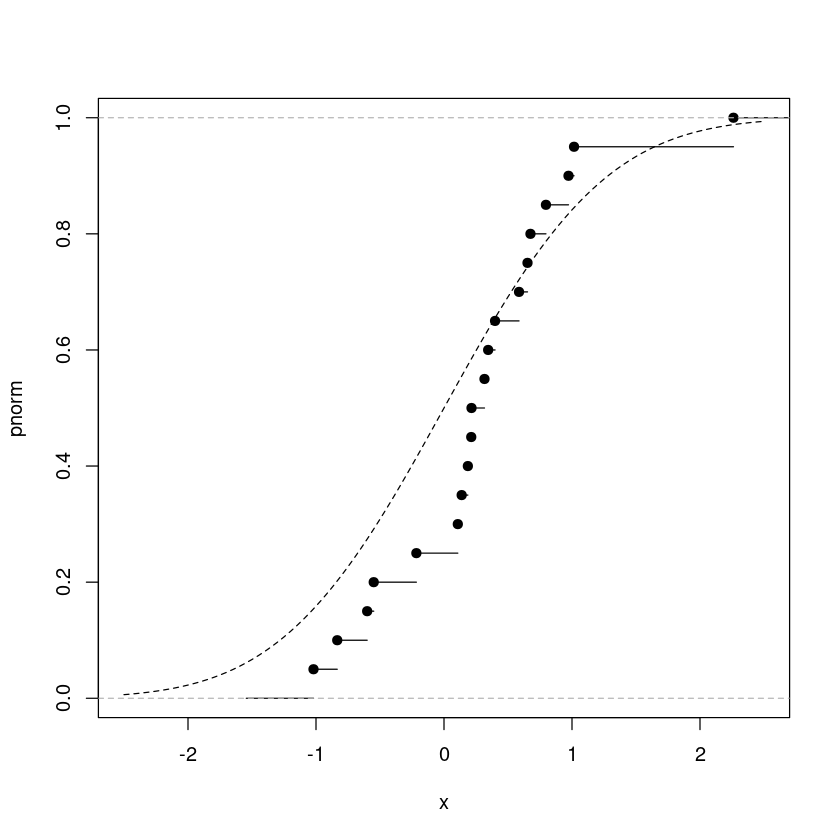

In [22]:
x <- rnorm(20)
my.ks.test(x, pnorm, mean=mean(x), sd=sd(x))
ks.test(x, pnorm, mean=mean(x), sd=sd(x))
shapiro.test(x)

plot(pnorm, from = -2.5, to = 2.5, lty="dashed")
plot(ecdf(x), add = TRUE)

# <a id='toc8_'></a>[Мощность критерия](#toc0_)

При n=5 простой критерий на 0.001 менее мощный (ошибок 2 рода на 0.1% больше)

In [23]:
alpha <- function(samples, a = 0.01) {
    list(ks    = mapply(function(x) ks.test(x, pnorm, mean = 5, sd = 2)$p.value > 1 - a, samples), 
         ksg   = mapply(function(x) cont_ks_test(x, pnorm, mean = 5, sd = 2)$p.value > 1 - a, samples), 
         my.ks = mapply(function(x) my.ks.test(x, pnorm, mean = 5, sd = 2)$p.v.my > 1 - a, samples))   
}

alpha.gamma <- function(n, k = 1000) {
    samples = list(alpha = seq(1, n), gamma1 = seq(1, n), gamma2 = seq(1, n))
    a <- data.frame(alpha(samples)) * 0 # инициализируем и обнулим матрицу

    for (k in 1:k){ # посчитаем сколько раз данные будут признаны нормальными
        samples = list(alpha = rnorm(n, mean = 5, sd = 2),  # покажет количество ош.1 рода
                       gamma1 = rexp(n, r = 1/2),           # мощность критерия на эксп.распр.
                       gamma2 = runif(n, min = 1, max = 9)) # мощность критерия на равн.распр.
        a <- a + data.frame(alpha(samples))

    }
    rbind(a["alpha", ] / k, 1 - a[c("gamma1", "gamma2"), ] / k) # поделим на количество повторов
}

alpha.gamma(5)
alpha.gamma(10)

,ks,ksg,my.ks
,<dbl>,<dbl>,<dbl>
alpha,0.009,0.009,0.011
gamma1,1.000,1.000,1.000
gamma2,0.991,0.991,0.990


,ks,ksg,my.ks
,<dbl>,<dbl>,<dbl>
alpha,0.011,0.011,0.011
gamma1,1.000,1.000,1.000
gamma2,0.996,0.996,0.995


# <a id='toc9_'></a>[Как устроен критерий Колмогорова в R](#toc0_)

In [24]:
.Call(stats:::C_pKolmogorov2x, 0.6/sqrt(5), 5, PACKAGE = "stats")   # интерфейс прямого вызова встроенных функций
kolmogorov.cdf(0.6, 5)

print(ks.test)

[1] 0.2163307

[1] 0.2150455

function (x, y, ..., alternative = c("two.sided", "less", "greater"), 
    exact = NULL) 
{
    alternative <- match.arg(alternative)
    DNAME <- deparse(substitute(x))
    x <- x[!is.na(x)]
    n <- length(x)
    if (n < 1L) 
        stop("not enough 'x' data")
    PVAL <- NULL
    if (is.numeric(y)) {
        DNAME <- paste(DNAME, "and", deparse(substitute(y)))
        y <- y[!is.na(y)]
        n.x <- as.double(n)
        n.y <- length(y)
        if (n.y < 1L) 
            stop("not enough 'y' data")
        if (is.null(exact)) 
            exact <- (n.x * n.y < 10000)
        METHOD <- "Two-sample Kolmogorov-Smirnov test"
        TIES <- FALSE
        n <- n.x * n.y/(n.x + n.y)
        w <- c(x, y)
        z <- cumsum(ifelse(order(w) <= n.x, 1/n.x, -1/n.y))
        if (length(unique(w)) < (n.x + n.y)) {
            if (exact) {
                warning("cannot compute exact p-value with ties")
                exact <- FALSE
            }
            else warning("p-value will be app

Распределение Колмогорова, это вам не это...

# <a id='toc10_'></a>[Заметки на полях](#toc0_)

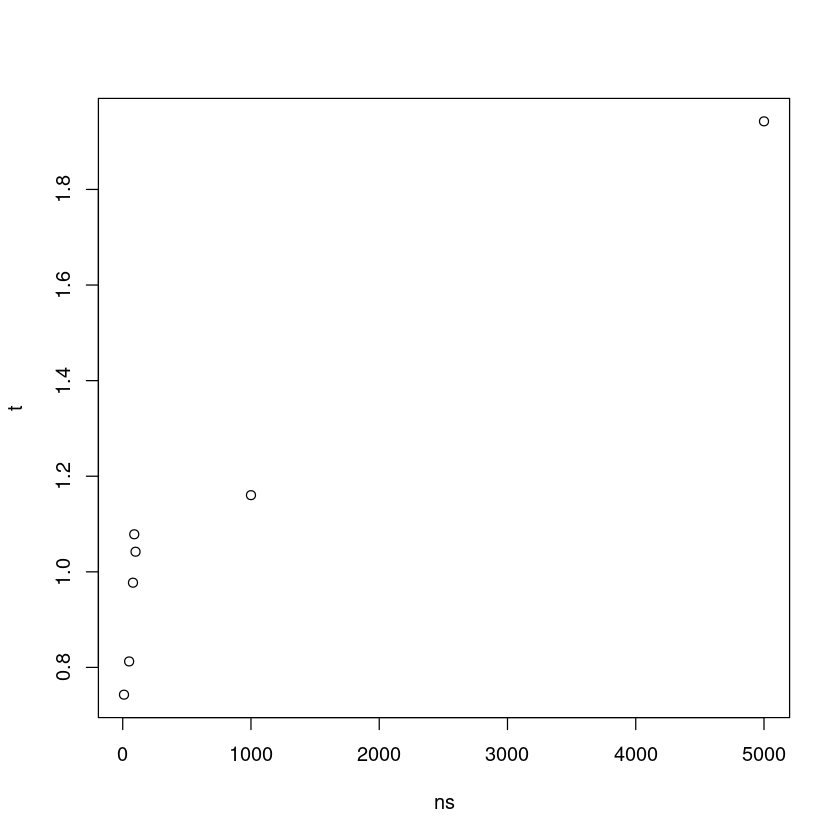

In [25]:
powers <- function(x, n) {
    j <- seq.int(from = 0, to = floor(n * (1 - x)))
    1 - x*sum(choose(n, j)*(1-x-j/n)^(n-j)*(x+j/n)^(j-1))
}

logs <- function(x, n) {
    j <- seq.int(from = 0, to = floor(n * (1 - x)))
    1 - x * sum(exp(lchoose(n, j) + (n - j) * log(1 - x - j/n) + (j - 1) * log(x + j/n)))
}

k = 10^4
n = 100
x = 0.4 / sqrt(n)

ns <- c(10,50,80,90,100,1000,5000)  # чито получилось 
t <- rev(c(16.9/8.7, (22.3/17.2 + 21.1/20.6) / 2, 22.3/21.4, 20.6/19.1, 8.6/8.8, 10.4/12.8, 39.6/53.3))

# логарифмы и степени по скорости равны при n около 100, меньше - быстрее степенная форма, больше - логарифмическая
plot(ns, t)

In [26]:
i <- 1
while (i < k) {
    powers(x, n)
    i <- i + 1
}
i

[1] 10000

In [27]:
i <- 1
while (i < k) {
    logs(x, n)
    i <- i + 1
}
i

[1] 10000